In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


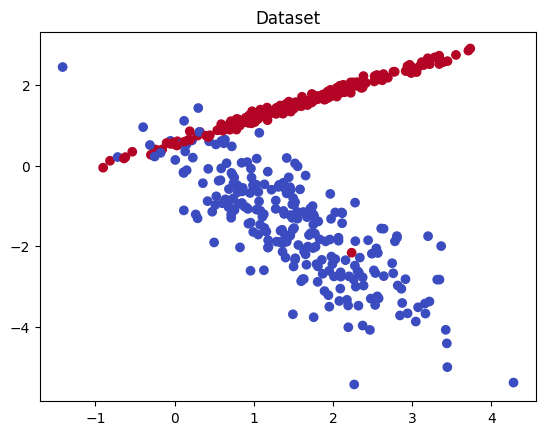

In [ ]:
X, y = make_classification(
    n_samples=500, n_features=2,
    n_redundant=0, n_clusters_per_class=1,
    class_sep=1.5, random_state=42
)

plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm')
plt.title("Dataset")
plt.show()


In [ ]:
class NaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.mean = {}
        self.var = {}
        self.prior = {}

        for c in self.classes:
            X_c = X[y == c]
            self.mean[c] = np.mean(X_c, axis=0)
            self.var[c] = np.var(X_c, axis=0) + 1e-6
            self.prior[c] = len(X_c) / len(X)

    def predict(self, X):
        preds = []
        for x in X:
            posteriors = []
            for c in self.classes:
                prior = np.log(self.prior[c])
                likelihood = -0.5 * np.sum(np.log(2 * np.pi * self.var[c]))
                likelihood -= 0.5 * np.sum(((x - self.mean[c])**2) / self.var[c])
                posteriors.append(prior + likelihood)
            preds.append(np.argmax(posteriors))
        return np.array(preds)


In [ ]:
nb = NaiveBayes()
nb.fit(X, y)
pred = nb.predict(X)

print("Naive Bayes Accuracy:", accuracy_score(y, pred))


Naive Bayes Accuracy: 0.952


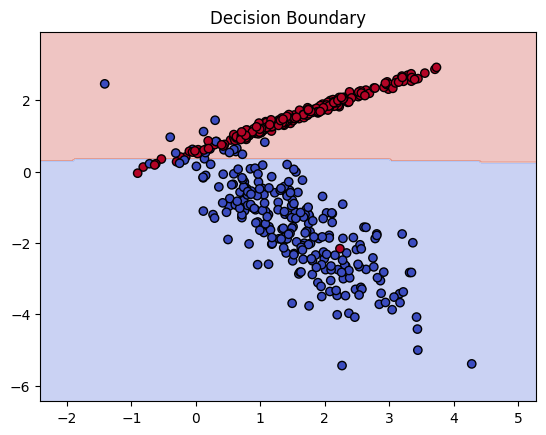

In [ ]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    pred = model.predict(grid)
    pred = pred.reshape(xx.shape)

    plt.contourf(xx, yy, pred, alpha=0.3, cmap="coolwarm")
    plt.scatter(X[:,0], X[:,1], c=y, cmap="coolwarm", edgecolor="k")
    plt.title("Decision Boundary")
    plt.show()

plot_decision_boundary(nb, X, y)


In [ ]:
class Perceptron:
    def __init__(self, lr=0.01, epochs=50):
        self.lr = lr
        self.epochs = epochs

    def fit(self, X, y):
        y_mod = np.where(y == 0, -1, 1)   # convert labels to -1, +1
        self.W = np.zeros(X.shape[1])
        self.b = 0

        for _ in range(self.epochs):
            for i in range(len(X)):
                if y_mod[i] * (np.dot(self.W, X[i]) + self.b) <= 0:
                    self.W += self.lr * y_mod[i] * X[i]
                    self.b += self.lr * y_mod[i]

    def predict(self, X):
        linear = X @ self.W + self.b
        return np.where(linear >= 0, 1, 0)


Perceptron Accuracy: 0.954


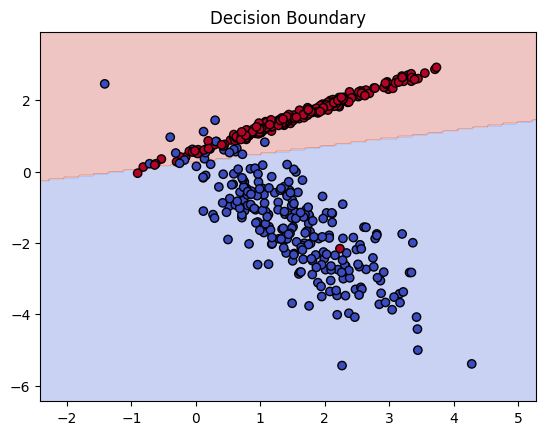

In [ ]:
perc = Perceptron(lr=0.01, epochs=20)
perc.fit(X, y)
pred = perc.predict(X)

print("Perceptron Accuracy:", accuracy_score(y, pred))
plot_decision_boundary(perc, X, y)


In [ ]:
class LinearSVM:
    def __init__(self, lr=0.001, lambda_val=0.01, epochs=200):
        self.lr = lr
        self.lambda_val = lambda_val
        self.epochs = epochs

    def fit(self, X, y):
        y_mod = np.where(y == 0, -1, 1)
        n, d = X.shape

        self.W = np.zeros(d)
        self.b = 0

        for _ in range(self.epochs):
            for i in range(n):
                condition = y_mod[i] * (np.dot(X[i], self.W) + self.b)

                if condition >= 1:
                    dW = 2 * self.lambda_val * self.W
                    db = 0
                else:
                    dW = 2 * self.lambda_val * self.W - (X[i] * y_mod[i])
                    db = -y_mod[i]

                self.W -= self.lr * dW
                self.b -= self.lr * db

    def predict(self, X):
        linear = X @ self.W + self.b
        return np.where(linear >= 0, 1, 0)


Linear SVM Accuracy: 0.952


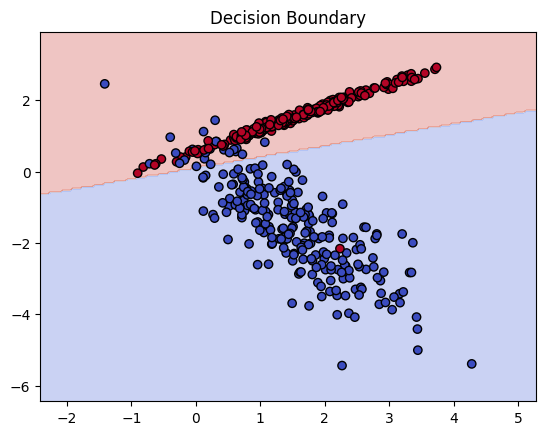

In [ ]:
svm = LinearSVM(lr=0.001, lambda_val=0.01, epochs=200)
svm.fit(X, y)
pred = svm.predict(X)

print("Linear SVM Accuracy:", accuracy_score(y, pred))
plot_decision_boundary(svm, X, y)


In [ ]:
def hinge_loss(X, y, W, b, C=1.0):
    y_mod = np.where(y == 0, -1, 1)
    distances = 1 - y_mod * (X @ W + b)
    distances = np.maximum(0, distances)
    return 0.5 * np.dot(W, W) + C * np.mean(distances)


In [ ]:
def train_svm_optimizer(X, y, lr, epochs, batch_size=None):
    y_mod = np.where(y == 0, -1, 1)
    n, d = X.shape
    W = np.zeros(d)
    b = 0
    C = 1.0

    losses = []

    for ep in range(epochs):

        if batch_size is None:
            idx = np.arange(n)
        else:
            idx = np.random.choice(n, batch_size, replace=False)

        Xb = X[idx]
        yb = y_mod[idx]

        margin = yb * (Xb @ W + b)
        misclassified = margin < 1

        dW = W - C * np.sum((Xb[misclassified].T * yb[misclassified]), axis=1)
        db = -C * np.sum(yb[misclassified])

        W -= lr * dW
        b -= lr * db

        losses.append(hinge_loss(X, y, W, b))

    return W, b, losses


In [ ]:
epochs = 200

# GD
W_gd, b_gd, loss_gd = train_svm_optimizer(X, y, lr=0.001, epochs=epochs, batch_size=None)

# SGD (batch size = 1)
W_sgd, b_sgd, loss_sgd = train_svm_optimizer(X, y, lr=0.001, epochs=epochs, batch_size=1)

# Mini-batch GD (batch size = 32)
W_mb, b_mb, loss_mb = train_svm_optimizer(X, y, lr=0.001, epochs=epochs, batch_size=32)


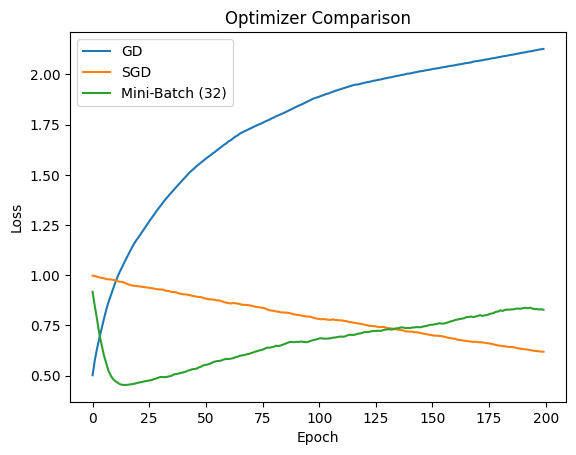

In [ ]:
plt.plot(loss_gd, label="GD")
plt.plot(loss_sgd, label="SGD")
plt.plot(loss_mb, label="Mini-Batch (32)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Optimizer Comparison")
plt.legend()
plt.show()
